![OCBC Hack-It! 2021](https://static.wixstatic.com/media/eb9e77_c22b27723f004f289ce16d23ad3e3f87~mv2.png/v1/fill/w_480,h_227,al_c,q_85,usm_0.66_1.00_0.01/eb9e77_c22b27723f004f289ce16d23ad3e3f87~mv2.webp) 

# OCBC Hack-It 2021
## Yusak Rabin (yusakrabin@gmail.com)

## Dataset: US Traffic 2015 (https://www.kaggle.com/jboysen/us-traffic-2015/)

## Dictionary/Source: Federal Highway Administration, US Department of Transport
* https://www.fhwa.dot.gov/policyinformation/tables/tmasdata/
* https://www.fhwa.dot.gov/policyinformation/tmguide/

## Google Colabotary:
https://colab.research.google.com/drive/1UgfETM_06I-WyDTvRwnt9kIbXDBrynkm

**Objective**: to detect patterns in the US Traffic datasets.

**Analysis Approach**:
1. **Exploratory**
   <p>Analyses of Stations and Traffic Volume datasets:
   <p>(1) Stations distribution across the states
   <p>(2) Road Type composition being monitored
   <p>(3) Location Type composition being monitored
   <p>(4) Hourly Traffic Volume Distribution based on:
   <br/>&emsp;- Location Type
   <br/>&emsp;- Road Type
   <br/>&emsp;- Direction of Travel
   <p>(5) Daily Traffic Volume Distribution based on:
   <br/>&emsp;- Monthly distribution
   <br/>&emsp;- State distribution

2. **Clustering**
   <p>Clustering analysis helps to uncover patterns hidden in the datasets. Interpretation of the pattern requires further study.
   <p> Thereare 2 clustering analyses performed:
   <p>(1) Volume clusters
   <p>(2) Hourly Distribution clusters

**Environment**:
<p>This code is executed in standard Google Colab environment (12.69GB memory). To ensure sufficient memory during execution, dataframe are freed and save into pickle in between processing.

In [ ]:
##### Directly download dataset from Kaggle
# for faster execution, this code is disabled & the zip file should be put in the same folder as this code
# for security, the kaggle credential is masked

'''
!mkdir ~/.kaggle #kaggle folder
!echo '{"username":"yrabin","key":"XXXXXb100c21372c4e98e2469efYYYYY"}' > ~/.kaggle/kaggle.json #kaggle credential into file
!chmod 600 ~/.kaggle/kaggle.json #kaggle credential file access
!pip install kaggle #kaggle library

!kaggle datasets download -d jboysen/us-traffic-2015 -p . #traffic dataset
!unzip us-traffic-2015.zip #unzip dataset
'''

 98% 436M/446M [00:11<00:00, 35.6MB/s]
100% 446M/446M [00:11<00:00, 39.5MB/s]
Archive:  us-traffic-2015.zip
  inflating: dot_traffic_2015.txt.gz  
  inflating: dot_traffic_stations_2015.txt.gz  


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# To save memory
import pickle
import gc

**Please ensure the file (*dot_traffic_stations_2015.txt.gz*) is in the same folder as this code.**

The traffic dataset is downloaded in the form of zip file containing 2 files:
1. **Station** dataset: records of monitoring station
2. **Traffic Volume** dataset: records of monitored volume from the station, brokedown hourly

# Station Dataset

In [ ]:
station_df = pd.read_csv('dot_traffic_stations_2015.txt.gz', compression='gzip')
station_df.head() # peek the data

,algorithm_of_vehicle_classification,algorithm_of_vehicle_classification_name,calibration_of_weighing_system,calibration_of_weighing_system_name,classification_system_for_vehicle_classification,concurrent_route_signing,concurrent_signed_route_number,direction_of_travel,direction_of_travel_name,fips_county_code,fips_state_code,functional_classification,functional_classification_name,hpms_sample_identifier,hpms_sample_type,lane_of_travel,lane_of_travel_name,latitude,longitude,lrs_identification,lrs_location_point,method_of_data_retrieval,method_of_data_retrieval_name,method_of_traffic_volume_counting,method_of_traffic_volume_counting_name,method_of_truck_weighing,method_of_truck_weighing_name,method_of_vehicle_classification,method_of_vehicle_classification_name,national_highway_system,number_of_lanes_in_direction_indicated,number_of_lanes_monitored_for_traffic_volume,number_of_lanes_monitored_for_truck_weight,number_of_lanes_monitored_for_vehicle_class,posted_route_signing,posted_signed_route_number,previous_station_id,primary_purpose,primary_purpose_name,record_type,sample_type_for_traffic_volume,sample_type_for_traffic_volume_name,sample_type_for_truck_weight,sample_type_for_truck_weight_name,sample_type_for_vehicle_classification,sample_type_for_vehicle_classification_name,second_type_of_sensor,shrp_site_identification,station_id,station_location,type_of_sensor,type_of_sensor_name,year_of_data,year_station_discontinued,year_station_established
0,NaN,NaN,NaN,NaN,13,3,091,7,West,59,6,2U,Urban: Principal Arterial - Other Freeways or ...,NaN,N,4,Other lanes,33.850898,117.814391,00000000091R,NaN,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,0,NaN,Y,5,5,0,0,3,091,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,N,Station not used for Heavy Vehicle Travel Info...,N,NaN,129130,LAKEVIEW AVENUE ORA91R10.091,L,Inductance loop,15,0,97
1,NaN,NaN,NaN,NaN,13,3,099,5,South,77,6,3R,Rural: Principal Arterial - Other,NaN,N,1,Outside (rightmost) lane,37.874697,121.219590,00000000099R,248336.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,0,NaN,Y,2,2,0,0,3,099,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,N,Station not used for Heavy Vehicle Travel Info...,N,NaN,100190,LITTLE JOHN CREEK SJ9912.526,L,Inductance loop,15,0,97
2,G,Axle spacing with Scheme F modified,NaN,NaN,15,1,005,1,North,93,6,1R,Rural: Principal Arterial - Interstate,NaN,N,2,Other lanes,41.441777,122.435010,00000000005R,750293.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),0,NaN,3,Permanent vehicle classification device,Y,2,2,0,2,1,005,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,NaN,NaN,H,Station used for Heavy Vehicle Travel Informat...,N,NaN,022940,EDGEWOOD SIS5R22.999,P,Piezoelectric,15,0,69
3,D,Vehicle length classification,M,Moving average of the steering axle of 3S2s,13,0,NaN,5,South,35,49,1U,Urban: Principal Arterial - Interstate,A00015293910,Y,1,Outside (rightmost) lane,40.516500,111.891520,000000001500,290600.0,2,Automated (telemetry),3,Permanent automatic traffic recorder (ATR),4,Portable weigh-in-motion system,3,Permanent vehicle classification device,Y,5,5,5,5,1,15,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,B,Station used for TMG sample and Strategic High...,N,Station not used for Heavy Vehicle Travel Info...,NaN,NaN,000302,I 15 12900 South M.P. 290.6,X,Radio wave,15,0,11
4,G,Axle spacing with Scheme F modified,0,NaN,14,1,000000,7,West,27,34,1U,Urban: Principal Arterial - Interstate,NaN,N,4,Other lanes,40.892373,74.484206,NaN,NaN,2,Automated (telemetry),2,Portable traffic recording device,0,NaN,3,Permanent vehicle classification device,Y,4,4,4,4,1,000080,NaN,P,Planning or traffic statistics purposes,S,T,Station used for Traffic Volume Trends,N,Station not used for any of the above,N,Station not used f

In [ ]:
station_df.info() # list the information available (columns), missing values, and columns type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28466 entries, 0 to 28465
Data columns (total 55 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   algorithm_of_vehicle_classification               18576 non-null  object 
 1   algorithm_of_vehicle_classification_name          17335 non-null  object 
 2   calibration_of_weighing_system                    8165 non-null   object 
 3   calibration_of_weighing_system_name               6681 non-null   object 
 4   classification_system_for_vehicle_classification  28466 non-null  int64  
 5   concurrent_route_signing                          28466 non-null  int64  
 6   concurrent_signed_route_number                    13592 non-null  object 
 7   direction_of_travel                               28466 non-null  int64  
 8   direction_of_travel_name                          28466 non-null  object 
 9   fips_county_code 

In [ ]:
station_df.shape # check amount of data

(28466, 55)

## State Distribution

Let's create unique ID that also identify the station location & show distribution accross States.

In [ ]:
# check County Code uniqueness
no_fips_county_code = station_df['fips_county_code'].nunique()
county_code = station_df['fips_state_code'].astype(str) +'-' + station_df['fips_county_code'].astype(str)
no_county_code = county_code.nunique()
print('nunique fips_county_code = ', no_fips_county_code)
print('nunique county_code = ', no_county_code)

# check Station ID uniqueness
no_station_id = station_df['station_id'].nunique()
county_station = station_df['fips_state_code'].astype(str) +'-' + station_df['fips_state_code'].astype(str) +'-' + station_df['station_id'].astype(str)
no_county_station = county_station.nunique()
print('nunique station_id = ', no_station_id)
print('nunique county_station = ', no_county_station)

nunique fips_county_code =  276
nunique county_code =  2091
nunique station_id =  6260
nunique county_station =  8541


County Code requires State Code to be unique, and similarly, Station ID needs State Code & County Code

In [ ]:
station_df['county_code'] = county_code # unique county code that includes state info
station_df['station_id'] = county_station # unique station ID that includes state & county info

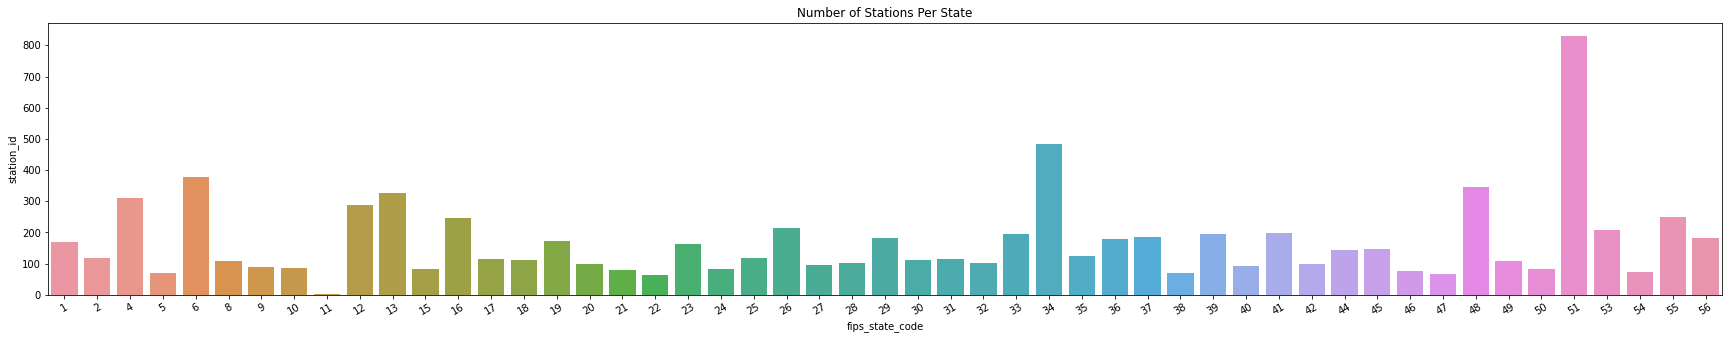

In [ ]:
# show the distribution of stations accross the state
fig, ax = plt.subplots(figsize=(30, 5))
ax.tick_params(axis='x', rotation=30)
ax.set_title('Number of Stations Per State')
sns.barplot(x = 'fips_state_code', y = 'station_id', data=station_df.groupby(by='fips_state_code', as_index=False)['station_id'].nunique())

State 51 (Virginia) has the highest number of station. This makes sense as the state borders Washington DC and hence, traffic monitoring is important for security reason.

## Road Type and Location Type Distribution

Let's split the Functional Classification into its component for detail analysis: Road Type (1-7) and Location Type (Urban/U, Rural/R), and plot the distribution.

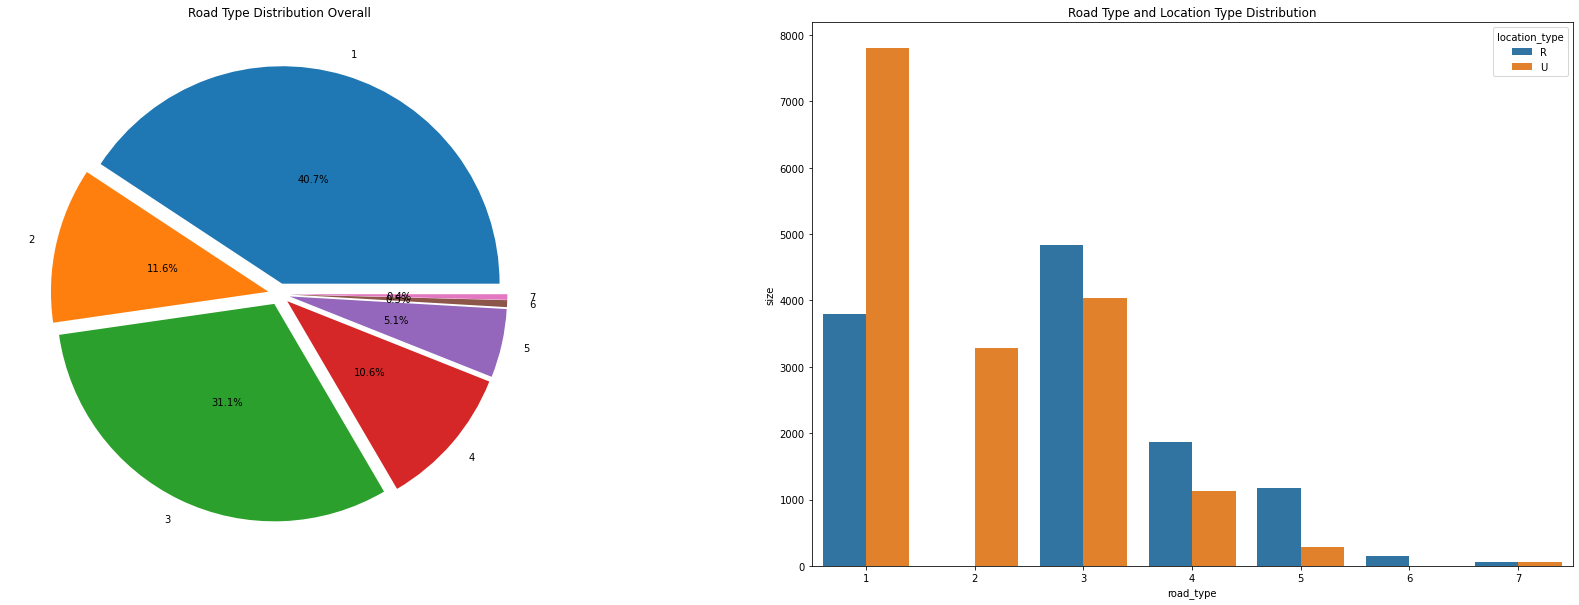

In [ ]:
# retrieve the road_type (1-7) from functional_classification
station_df['road_type'] = station_df['functional_classification'].astype(str).str[0]
station_df['road_type'] = station_df['road_type'].astype('category')

# retrieve the location_type (U, R) from functional_classification
station_df['location_type'] = station_df['functional_classification'].astype(str).str[1]
station_df['location_type'] = station_df['location_type'].astype('category')


# plot the distibution
fig, ax = plt.subplots(figsize=(30, 10), ncols=2)

ax[0].set_title('Road Type Distribution Overall') # Road Type distribution overall
ax[0].pie(x=station_df.groupby('road_type').size(), autopct="%.1f%%", explode=[0.05]*7, labels=station_df.groupby('road_type').size().keys(), pctdistance=0.5)

ax[1].set_title('Road Type and Location Type Distribution') # Road Type distribution by location type
sns.barplot(x='road_type', y='size', ci=None, hue='location_type', data=station_df.groupby(['road_type','location_type'], as_index=False).size(), ax=ax[1])

There are more stations at Urban location compared to Rural:
* Most observation points are gathered from stations on big/major roads (road_type: 1/Interstate, 2/Principal Arterial Freeways & Highways, 3/Principal Arterial Other)
* There are very few observations on small roads (road_type: 6/minor collector and 7/local roads).

Given the distribution of road types above, any analysis results can only be interpreted as traffic at Interstates and Principla Arterials. 


## County information extract

County Code to be merged into Traffic Volume dataset.

In [ ]:
station_id_df = station_df[['station_id', 'county_code']].drop_duplicates()
station_id_df

,station_id,county_code
0,6-6-129130,6-59
1,6-6-100190,6-77
2,6-6-022940,6-93
3,49-49-000302,49-35
4,34-34-W01136,34-27
...,...,...
28303,51-51-040282,51-760
28305,51-51-190302,51-3
28351,4-4-100113,4-13
28390,33-33-339003,33-19


## Clean up

In [ ]:
# Save Station DF, in case it is needed later
with open('station_df.pkl', 'wb') as pickle_out:
    pickle.dump(station_df, pickle_out)

# Clean-up Station DF
del(station_df)
gc.collect()

171

# Traffic Volume Dataset

In [ ]:
traffic_df = pd.read_csv('dot_traffic_2015.txt.gz', compression='gzip')
traffic_df.head()

,date,day_of_data,day_of_week,direction_of_travel,direction_of_travel_name,fips_state_code,functional_classification,functional_classification_name,lane_of_travel,month_of_data,record_type,restrictions,station_id,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
0,2015-04-07,7,3,1,North,56,3R,Rural: Principal Arterial - Other,1,4,3,NaN,000084,4,3,2,4,43,78,116,144,132,115,150,184,169,136,129,89,122,124,110,69,73,28,12,6,15
1,2015-09-26,26,7,7,West,21,1U,Urban: Principal Arterial - Interstate,2,9,3,NaN,056P94,381,252,218,194,220,348,453,679,826,962,1158,1379,1376,1383,1453,1617,1669,1308,1068,928,885,798,650,613,15
2,2015-06-16,16,3,3,East,6,1U,Urban: Principal Arterial - Interstate,0,6,3,NaN,077590,585,408,328,364,696,1929,4228,5634,5673,4636,3925,3827,4049,3954,4077,4244,4405,4609,4361,3272,2243,2050,1453,892,15
3,2015-04-26,26,1,5,South,55,1U,Urban: Principal Arterial - Interstate,1,4,3,NaN,450001,105,73,68,66,77,113,254,367,487,668,870,996,1003,1000,1043,1011,959,851,708,559,457,297,207,110,15
4,2015-05-23,23,7,3,East,4,4R,Rural: Minor Arterial,0,5,3,NaN,102210,6,4,2,3,1,10,17,52,64,68,82,96,99,87,87,83,61,55,35,29,21,23,9,7,15


In [ ]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7140391 entries, 0 to 7140390
Data columns (total 38 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   date                                       object 
 1   day_of_data                                int64  
 2   day_of_week                                int64  
 3   direction_of_travel                        int64  
 4   direction_of_travel_name                   object 
 5   fips_state_code                            int64  
 6   functional_classification                  object 
 7   functional_classification_name             object 
 8   lane_of_travel                             int64  
 9   month_of_data                              int64  
 10  record_type                                int64  
 11  restrictions                               float64
 12  station_id                                 object 
 13  traffic_volume_counted_after_0000_to_0100 

The variable sizes (float64, int64, object) are to big, taking over 2GB. We should shrink the size by converting the data types as appropriate.

In [ ]:
traffic_df.describe()

,day_of_data,day_of_week,direction_of_travel,fips_state_code,lane_of_travel,month_of_data,record_type,restrictions,traffic_volume_counted_after_0000_to_0100,traffic_volume_counted_after_0100_to_0200,traffic_volume_counted_after_0200_to_0300,traffic_volume_counted_after_0300_to_0400,traffic_volume_counted_after_0400_to_0500,traffic_volume_counted_after_0500_to_0600,traffic_volume_counted_after_0600_to_0700,traffic_volume_counted_after_0700_to_0800,traffic_volume_counted_after_0800_to_0900,traffic_volume_counted_after_0900_to_1000,traffic_volume_counted_after_1000_to_1100,traffic_volume_counted_after_1100_to_1200,traffic_volume_counted_after_1200_to_1300,traffic_volume_counted_after_1300_to_1400,traffic_volume_counted_after_1400_to_1500,traffic_volume_counted_after_1500_to_1600,traffic_volume_counted_after_1600_to_1700,traffic_volume_counted_after_1700_to_1800,traffic_volume_counted_after_1800_to_1900,traffic_volume_counted_after_1900_to_2000,traffic_volume_counted_after_2000_to_2100,traffic_volume_counted_after_2100_to_2200,traffic_volume_counted_after_2200_to_2300,traffic_volume_counted_after_2300_to_2400,year_of_data
count,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7140391.0,0.0,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7.140391e+06,7140391.0
mean,1.572650e+01,4.013872e+00,3.883486e+00,2.966967e+01,1.291672e+00,6.520263e+00,3.0,NaN,1.145878e+02,7.874558e+01,6.622503e+01,7.016138e+01,1.171851e+02,2.454065e+02,4.334301e+02,5.833799e+02,5.774976e+02,5.600694e+02,5.811083e+02,6.184133e+02,6.501346e+02,6.635075e+02,7.009825e+02,7.497160e+02,7.770437e+02,7.565536e+02,6.173322e+02,4.793756e+02,3.906426e+02,3.274747e+02,2.534447e+02,1.798298e+02,15.0
std,8.769343e+00,1.997511e+00,2.286816e+00,1.670612e+01,1.080419e+00,3.455234e+00,0.0,NaN,2.818492e+02,2.202875e+02,2.102642e+02,2.242483e+02,3.227085e+02,5.723301e+02,8.359078e+02,9.984941e+02,9.594217e+02,8.917308e+02,8.970572e+02,9.371717e+02,1.001836e+03,1.024515e+03,1.092236e+03,1.143318e+03,1.173933e+03,1.172116e+03,1.061545e+03,9.203711e+02,8.290271e+02,7.989146e+02,7.284074e+02,6.901713e+02,0.0
min,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,3.0,NaN,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-3.061000e+03,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,15.0
25%,8.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00,4.000000e+00,3.0,NaN,1.300000e+01,8.000000e+00,7.000000e+00,7.000000e+00,1.200000e+01,2.800000e+01,5.600000e+01,9.000000e+01,1.070000e+02,1.230000e+02,1.370000e+02,1.490000e+02,1.590000e+02,1.620000e+02,1.700000e+02,1.830000e+02,1.860000e+02,1.740000e+02,1.310000e+02,9.500000e+01,7.200000e+01,5.400000e+01,3.600000e+01,2.200000e+01,15.0
50%,1.600000e+01,4.000000e+00,4.000000e+00,3.000000e+01,1.000000e+00,7.000000e+00,3.0,NaN,4.200000e+01,2.700000e+01,2.100000e+01,2.300000e+01,3.800000e+01,8.600000e+01,1.700000e+02,2.640000e+02,2.850000e+02,3.030000e+02,3.320000e+02,3.620000e+02,3.860000e+02,3.910000e+02,4.090000e+02,4.380000e+02,4.520000e+02,4.320000e+02,3.370000e+02,2.520000e+02,1.980000e+02,1.550000e+02,1.090000e+02,7.000000e+01,15.0
75%,2.300000e+01,6.000000e+00,5.000000e+00,4.400000e+01,2.000000e+00,1.000000e+01,3.0,NaN,1.260000e+02,8.500000e+01,7.000000e+01,7.500000e+01,1.180000e+02,2.410000e+02,4.570000e+02,6.570000e+02,6.570000e+02,6.450000e+02,6.810000e+02,7.250000e+02,7.610000e+02,7.770000e+02,8.220000e+02,8.910000e+02,9.340000e+02,9.070000e+02,7.220000e+02,5.510000e+02,4.470000e+02,3.670000e+02,2.780000e

Some columns are:
* unused:
  1. *restrictions*: entire column is NaN
* redundant:
  1. *date*: there's already *day_of_data* and *month_of_data*.
  2. *year_of_data*: the year is fixed, i.e. 2015.
  3. *direction_of_travel_name*: *direction_of_travel* is sufficient for analysis.
  4. *functional_classification_name*: *functional_classification* is sufficient for analysis.
  5. *record_type*: entire column has the same value

## Preprocessing

Compress used columns by converting its data types and Delete unused & redundant columns.

### Compress the size

In [ ]:
# Catagory columns
category_cols = ['day_of_data', 'month_of_data', 'day_of_week', 'direction_of_travel',
                 'fips_state_code', 'functional_classification','lane_of_travel']
for c in category_cols:
    traffic_df[c] = traffic_df[c].astype('category')

traffic_df['station_id'] = traffic_df['fips_state_code'].astype(str) +'-' + traffic_df['fips_state_code'].astype(str) +'-' + traffic_df['station_id'].astype(str)
traffic_df['station_id'] = traffic_df['station_id'].astype('category')

In [ ]:
prefix = 'traffic_volume_counted_after_' # prefix of hourly columns to be renamed, for simplicity

hour_cols = [] # hour columns
names = {} # column for renaming

for c in traffic_df.columns.values.tolist():
    if c.startswith(prefix):
        hour_cols.append(c[len(prefix):])
        names[c] = c[len(prefix):]

traffic_df.rename(columns=names, inplace=True)

# convert the hour values to smaller data type
for h in hour_cols:
    traffic_df[h] = traffic_df[h].astype('int16')

### Add/Remove Columns

New columns created:
* *road_type* (1-7) and *location_type* (**R**ural/**U**rban)
* *total* of each row (hourly observation)
* *county_code* of the station_id, by merging the information from Stations dataset

Removed columns are the unused and redundant columns as described above.

In [ ]:
# Add road_type from functional_classification
traffic_df['road_type'] = traffic_df['functional_classification'].astype(str).str[0]
traffic_df['road_type'] = traffic_df['road_type'].astype('category')
category_cols.append('road_type')

# Add location_type from functional_classification
traffic_df['location_type'] = traffic_df['functional_classification'].astype(str).str[1]
traffic_df['location_type'] = traffic_df['location_type'].astype('category')
category_cols.append('location_type')

# Add total as sum of hourly volumes
traffic_df['total'] = traffic_df[hour_cols].sum(axis=1)
traffic_df['total'] = traffic_df['total'].astype('int32')

# Add county code as sum of hourly volumes
traffic_df = traffic_df.merge(station_id_df)
traffic_df['county_code'] = traffic_df['county_code'].astype('category')
category_cols.append('county_code')

In [ ]:
# Remove redundant columns
traffic_df.drop(['record_type', 'restrictions', 'date', 'direction_of_travel_name',
                 'functional_classification_name', 'year_of_data'], axis=1, inplace=True)

# peek Traffic Volume dataframe again
traffic_df.head()

,day_of_data,day_of_week,direction_of_travel,fips_state_code,functional_classification,lane_of_travel,month_of_data,station_id,0000_to_0100,0100_to_0200,0200_to_0300,0300_to_0400,0400_to_0500,0500_to_0600,0600_to_0700,0700_to_0800,0800_to_0900,0900_to_1000,1000_to_1100,1100_to_1200,1200_to_1300,1300_to_1400,1400_to_1500,1500_to_1600,1600_to_1700,1700_to_1800,1800_to_1900,1900_to_2000,2000_to_2100,2100_to_2200,2200_to_2300,2300_to_2400,road_type,location_type,total,county_code
0,7,3,1,56,3R,1,4,56-56-000084,4,3,2,4,43,78,116,144,132,115,150,184,169,136,129,89,122,124,110,69,73,28,12,6,3,R,2042,56-39
1,26,7,5,56,3R,1,12,56-56-000084,11,0,1,1,5,41,53,44,98,143,233,333,389,358,335,363,293,242,129,100,46,105,79,20,3,R,3422,56-39
2,23,4,1,56,3R,1,9,56-56-000084,10,4,4,11,61,223,289,315,467,518,503,468,442,435,370,335,358,364,266,182,167,129,53,17,3,R,5991,56-39
3,13,2,1,56,3R,1,4,56-56-000084,4,1,1,2,37,72,120,160,150,117,147,188,208,176,180,147,143,143,111,82,81,50,20,5,3,R,2345,56-39
4,22,1,1,56,3R,1,11,56-56-000084,10,3,2,2,39,66,108,63,51,53,152,183,166,163,159,116,107,60,47,49,70,35,15,12,3,R,1731,56-39


In [ ]:
traffic_df.memory_usage()

Index                        57343256
day_of_data                   7169435
day_of_week                   7168283
direction_of_travel           7168307
fips_state_code               7170875
functional_classification     7168323
lane_of_travel                7168307
month_of_data                 7168323
station_id                   57343256
0000_to_0100                 14335814
0100_to_0200                 14335814
0200_to_0300                 14335814
0300_to_0400                 14335814
0400_to_0500                 14335814
0500_to_0600                 14335814
0600_to_0700                 14335814
0700_to_0800                 14335814
0800_to_0900                 14335814
0900_to_1000                 14335814
1000_to_1100                 14335814
1100_to_1200                 14335814
1200_to_1300                 14335814
1300_to_1400                 14335814
1400_to_1500                 14335814
1500_to_1600                 14335814
1600_to_1700                 14335814
1700_to_1800

## Hourly Traffic Analysis

In Hourly traffic analysis, we try to find the pattern of hourvly volume distribution within a day. The assumption in this analysis:
* there is difference between Rural & Urban hourly distribution due to differences in people's activity patterns in these different areas.
* there is difference between Weekdays and Weekend hourly distribution due to differences in people's activity pattern during weekdays and weekend.
* there is different patterns in hourly traffic distribution based on direction of travel. Distribution pattern will be most apprent if there are intraday travels, e.g. morning and evening opposite travel direction. 

In [ ]:
hourly_df = traffic_df[category_cols].copy()

for h in hour_cols:
    hourly_df[h] = traffic_df[h] / traffic_df['total']
    hourly_df[h] = hourly_df[h].astype('float16')

In [ ]:
#hourly_df['top_peak_hour'] = hourly_df[hours].idxmax(axis=1)
#hourly_df['top_offpeak_hour'] = hourly_df[hours].idxmin(axis=1)
hourly_df.head()

,day_of_data,month_of_data,day_of_week,direction_of_travel,fips_state_code,functional_classification,lane_of_travel,road_type,location_type,county_code,0000_to_0100,0100_to_0200,0200_to_0300,0300_to_0400,0400_to_0500,0500_to_0600,0600_to_0700,0700_to_0800,0800_to_0900,0900_to_1000,1000_to_1100,1100_to_1200,1200_to_1300,1300_to_1400,1400_to_1500,1500_to_1600,1600_to_1700,1700_to_1800,1800_to_1900,1900_to_2000,2000_to_2100,2100_to_2200,2200_to_2300,2300_to_2400
0,7,4,3,1,56,3R,1,3,R,56-39,0.001959,0.001470,0.000979,0.001959,0.021057,0.038208,0.056793,0.070496,0.064636,0.056305,0.073486,0.090088,0.082764,0.066589,0.063171,0.043579,0.059753,0.060730,0.053864,0.033783,0.035736,0.013710,0.005878,0.002939
1,26,12,7,5,56,3R,1,3,R,56-39,0.003214,0.000000,0.000292,0.000292,0.001461,0.011978,0.015488,0.012856,0.028641,0.041779,0.068115,0.097290,0.113647,0.104614,0.097900,0.106079,0.085632,0.070740,0.037689,0.029221,0.013443,0.030685,0.023087,0.005844
2,23,9,4,1,56,3R,1,3,R,56-39,0.001669,0.000668,0.000668,0.001836,0.010185,0.037231,0.048248,0.052582,0.077942,0.086487,0.083984,0.078125,0.073792,0.072632,0.061768,0.055908,0.059753,0.060760,0.044403,0.030380,0.027878,0.021530,0.008850,0.002838
3,13,4,2,1,56,3R,1,3,R,56-39,0.001706,0.000427,0.000427,0.000853,0.015778,0.030701,0.051178,0.068237,0.063965,0.049896,0.062683,0.080200,0.088684,0.075073,0.076782,0.062683,0.060974,0.060974,0.047333,0.034973,0.034546,0.021317,0.008530,0.002132
4,22,11,1,1,56,3R,1,3,R,56-39,0.005775,0.001733,0.001156,0.001156,0.022537,0.038116,0.062378,0.036407,0.029465,0.030624,0.087830,0.105713,0.095886,0.094177,0.091858,0.067017,0.061829,0.034668,0.027145,0.028305,0.040436,0.020218,0.008667,0.006931


In [ ]:
# common function to generate summarized dataframe
def create_hourly_summary(category_cols, df):
    summary_df = df.groupby(by=category_cols, as_index=False)[hour_cols].mean()
    return summary_df.melt(id_vars=category_cols, value_vars=hour_cols, var_name='Hours', value_name='RelativeVolume')

### By Location Type (Rural vs Urban)

In [ ]:
dayloc_hourly_df = create_hourly_summary(['day_of_week', 'location_type'], hourly_df)
dayloc_hourly_df

,day_of_week,location_type,Hours,RelativeVolume
0,1,R,0000_to_0100,0.011559
1,1,U,0000_to_0100,0.017166
2,2,R,0000_to_0100,0.007496
3,2,U,0000_to_0100,0.007442
4,3,R,0000_to_0100,0.007423
...,...,...,...,...
331,5,U,2300_to_2400,0.013962
332,6,R,2300_to_2400,0.014793
333,6,U,2300_to_2400,0.017883
334,7,R,2300_to_2400,0.016174


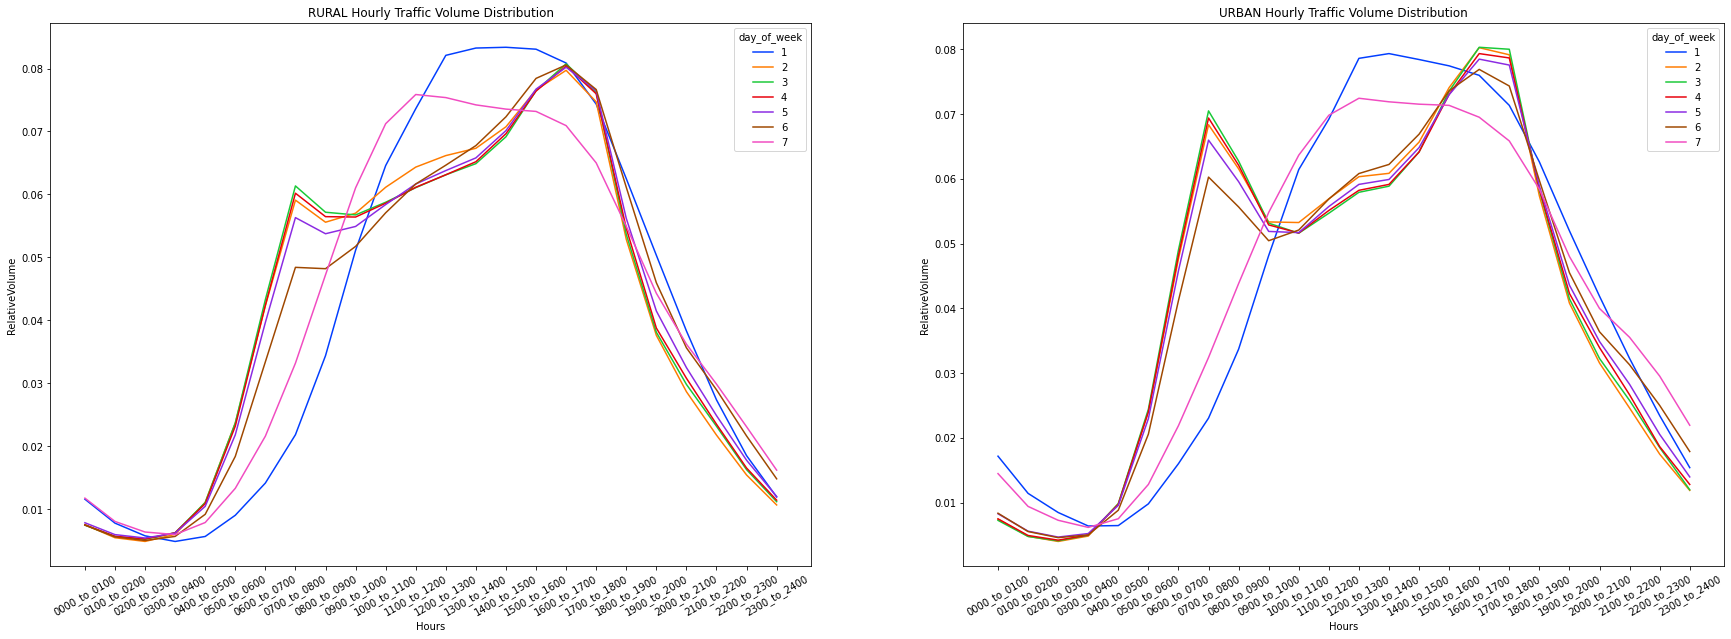

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10), ncols=2)

# Rural chart
ax[0].tick_params(axis='x', rotation=30)
ax[0].set_title('RURAL Hourly Traffic Volume Distribution')
sns.lineplot(x='Hours', y='RelativeVolume', ci=None, hue='day_of_week', palette='bright',
             data=dayloc_hourly_df['R' == dayloc_hourly_df['location_type']], ax=ax[0])

# Urban chart
ax[1].tick_params(axis='x', rotation=30)
ax[1].set_title('URBAN Hourly Traffic Volume Distribution')
sns.lineplot(x='Hours', y='RelativeVolume', ci=None, hue='day_of_week', palette='bright',
             data=dayloc_hourly_df['U' == dayloc_hourly_df['location_type']], ax=ax[1])

From the above charts,
1. the hourly distributions of Rural and Urban are very similar; the main difference observed is on the morning peak. Urban distribution has bigger morning peak than Rural distribution.
2. there are differences observed above is between weekday and weekend,
<br/>&emsp;- there are less traffic during weekday nights (0000 - 0300) and the traffic picks up faster (after 0300).
<br/>&emsp;- the peak traffic volume in the rural area is highest on weekend (saturday), and weekday traffic's peak is highest in urban area. 

### By Road Types (Weekdays vs Weekend)

Given the above observation on location type, we follow up on Weekday/Weekend analysis and check if there's also different pattern for road type.

In [ ]:
weekdays = [2,3,4,5,6]
weekend = [1, 7]

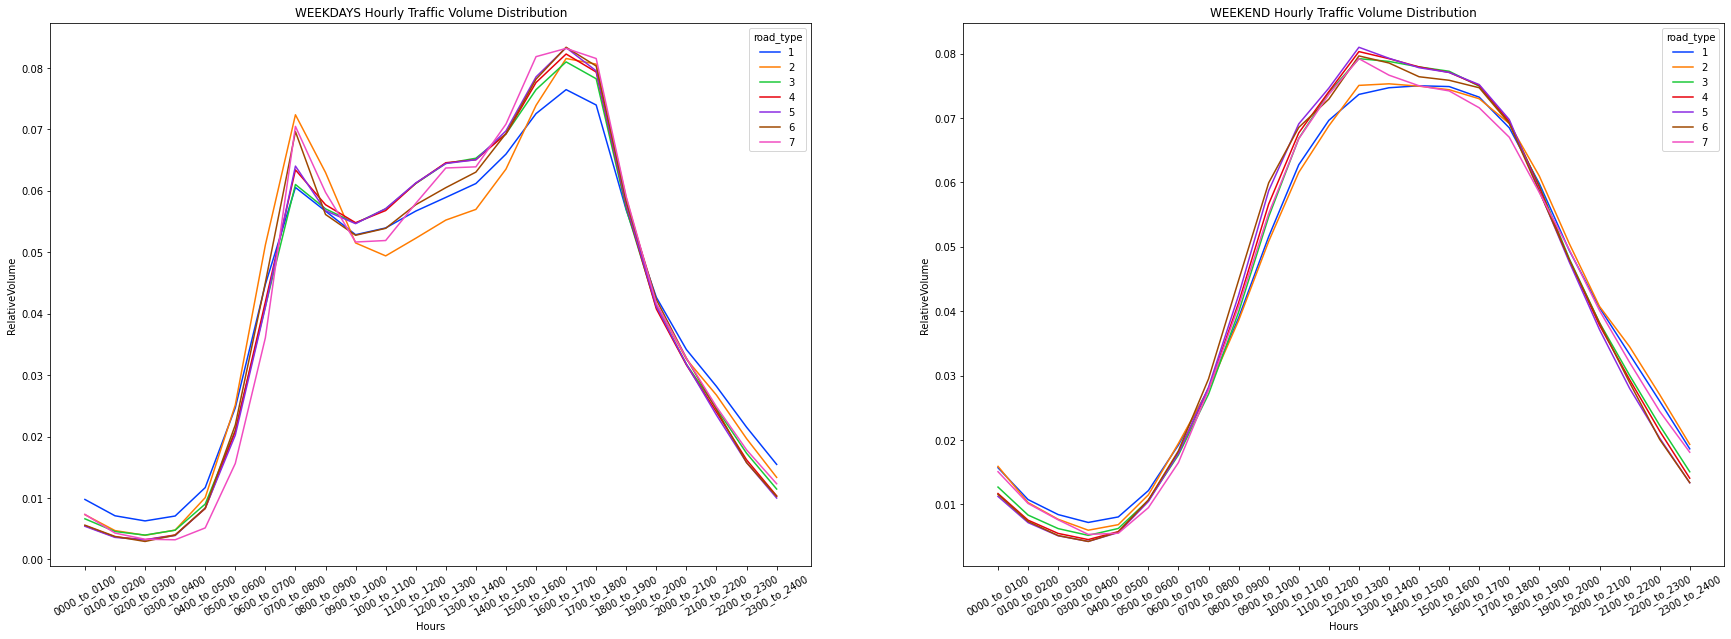

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10), ncols=2)

# WeekDAY chart
ax[0].tick_params(axis='x', rotation=30)
ax[0].set_title('WEEKDAYS Hourly Traffic Volume Distribution')
sns.lineplot(x='Hours', y='RelativeVolume', ci=None, hue='road_type', palette='bright', ax=ax[0],
             data=create_hourly_summary(['road_type'], hourly_df[hourly_df['day_of_week'].isin(weekdays)]))

# WeekEND chart
ax[1].tick_params(axis='x', rotation=30)
ax[1].set_title('WEEKEND Hourly Traffic Volume Distribution')
sns.lineplot(x='Hours', y='RelativeVolume', ci=None, hue='road_type', palette='bright', ax=ax[1],
             data=create_hourly_summary(['road_type'], hourly_df[hourly_df['day_of_week'].isin(weekend)]))

The above charts show the differences between Weekdays and Weekend traffic very clearly.
However, the pattern among road types are all similar. One observation that can be made is the lowest peak on both weekdays and weekend are for road type 1 (interstate) and 2 (principal arteries); this means the distribution of traffic at both road types are more evenly distributed accross the hours (on weekdays and weekend alike).

### By Direction of Travel

In this analysis we are checking if the nature of traffic is intraday travel, e.g. northern travel in the morning and southern travel at night; if so, there will be peaks at different hour for different direction, or more evently distributed accross the hours.

In [ ]:
direction_df = traffic_df.groupby(by='direction_of_travel', as_index=False)[hour_cols].sum()
direction_df = direction_df.melt(id_vars='direction_of_travel', value_vars=hour_cols, var_name='Hours', value_name='Volume')
direction_df

,direction_of_travel,Hours,Volume
0,0,0000_to_0100,7548262.0
1,1,0000_to_0100,239453050.0
2,2,0000_to_0100,1376123.0
3,3,0000_to_0100,162125936.0
4,4,0000_to_0100,1635563.0
...,...,...,...
235,5,2300_to_2400,355367908.0
236,6,2300_to_2400,2205387.0
237,7,2300_to_2400,242473357.0
238,8,2300_to_2400,2817150.0


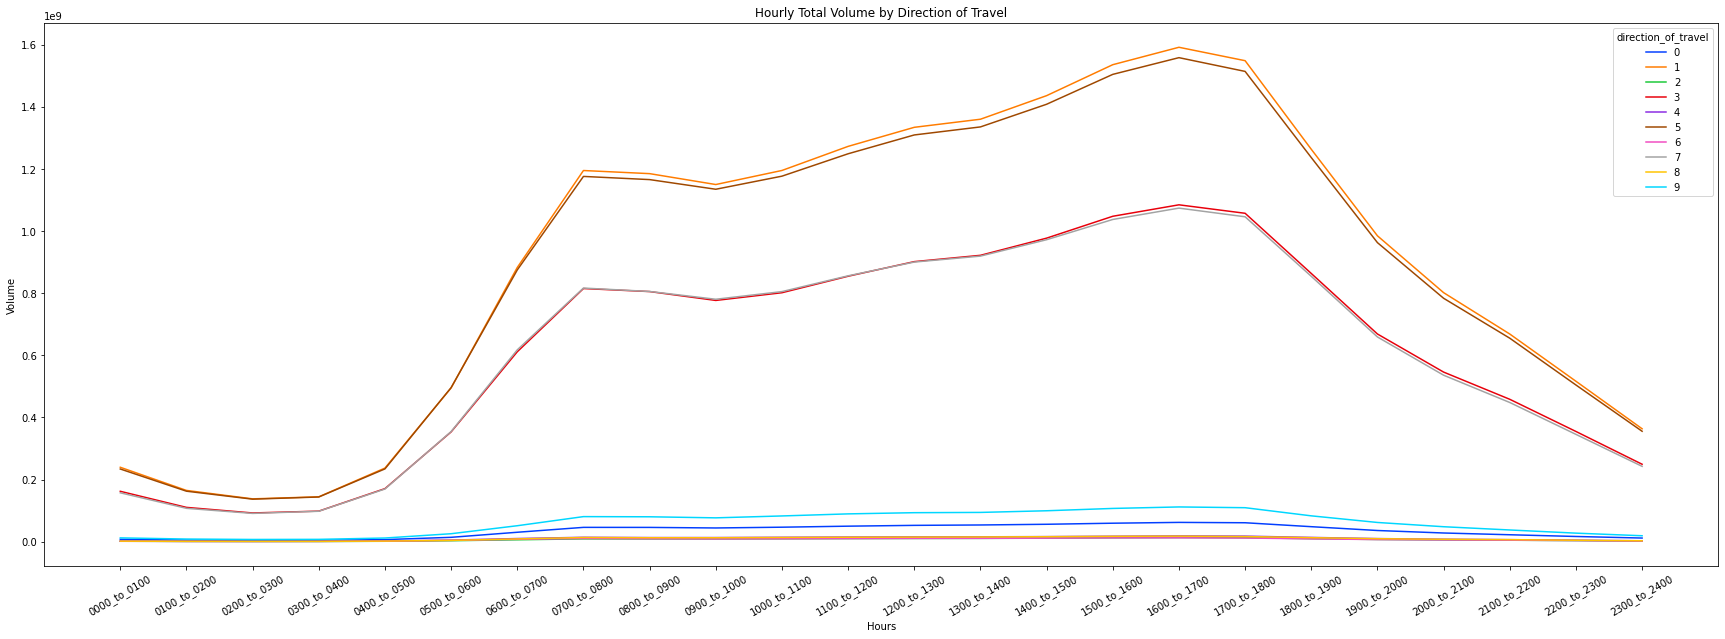

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10))

ax.tick_params(axis='x', rotation=30)
ax.set_title('Hourly Total Volume by Direction of Travel')
sns.lineplot(x='Hours', y='Volume', ci=None, hue='direction_of_travel', palette='bright', data=direction_df)

The above chart does not indicate dominance of intraday travels. Traffic in all direction peak at around the same time at specific hour (0700 in the morning and 1700 in the evening).
<br/>North & South have the biggest share of volumes, significantly higher than East & West.
<br/>The mixed direction indicators (Northeast, Southwest, etc.) are the lowest. This maybe because fewer stations use mixed direction indicators.

### Clean up

Save *hourly_df* dataframe for possible further processing later and clear all others.

In [ ]:
# Save df, in case it is needed later
with open('hourly_df.pkl', 'wb') as pickle_out:
    pickle.dump(hourly_df, pickle_out)

# Clean up df
del(hourly_df); del(dayloc_hourly_df); del(direction_df)
gc.collect()

321

## Daily Traffic Analysis

In [ ]:
daily_df = traffic_df.groupby(by=['day_of_data', 'month_of_data', 'day_of_week'], as_index=False)['total'].mean()
daily_df.dropna(inplace=True)
daily_df

,day_of_data,month_of_data,day_of_week,total
4,1,1,5,6738.061730
7,1,2,1,6858.319368
14,1,3,1,7594.295358
24,1,4,4,11156.860459
33,1,5,6,12564.096009
...,...,...,...,...
2548,31,5,1,8961.545649
2567,31,7,6,13027.889561
2570,31,8,2,10230.672400
2589,31,10,7,8462.516464


### By Month

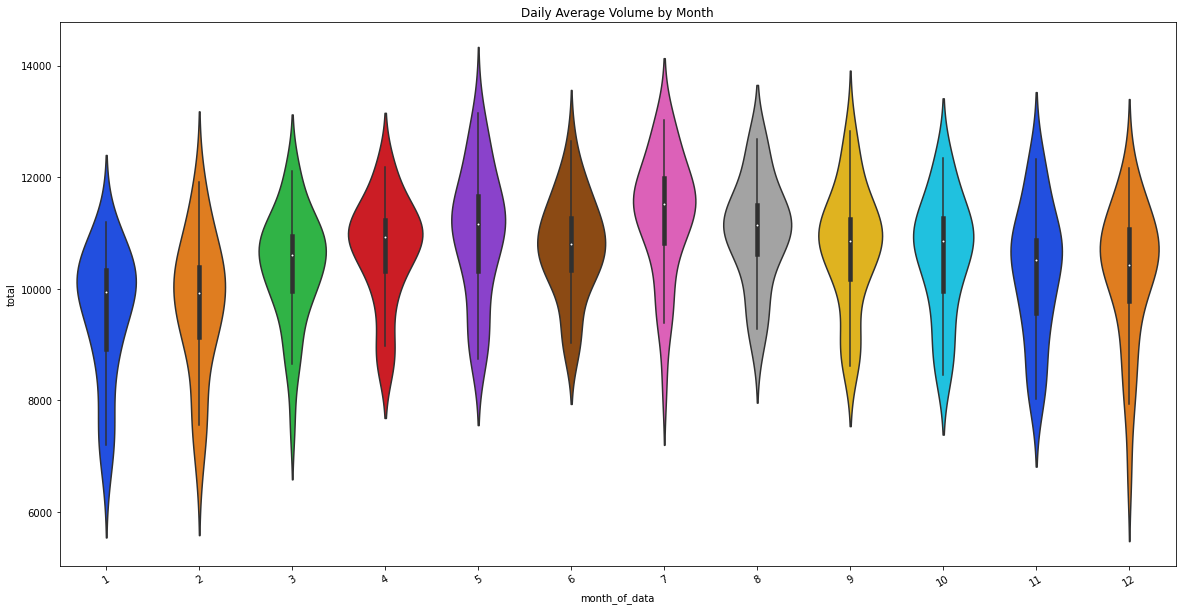

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.tick_params(axis='x', rotation=30)
ax.set_title('Daily Average Volume by Month')
sns.violinplot(x='month_of_data', y='total', palette='bright', data=daily_df)

Daily traffic volumes peak around months May to August. This observation is expected as these months correspond to summer school holidays.

### By RoadType and DayOfWeek

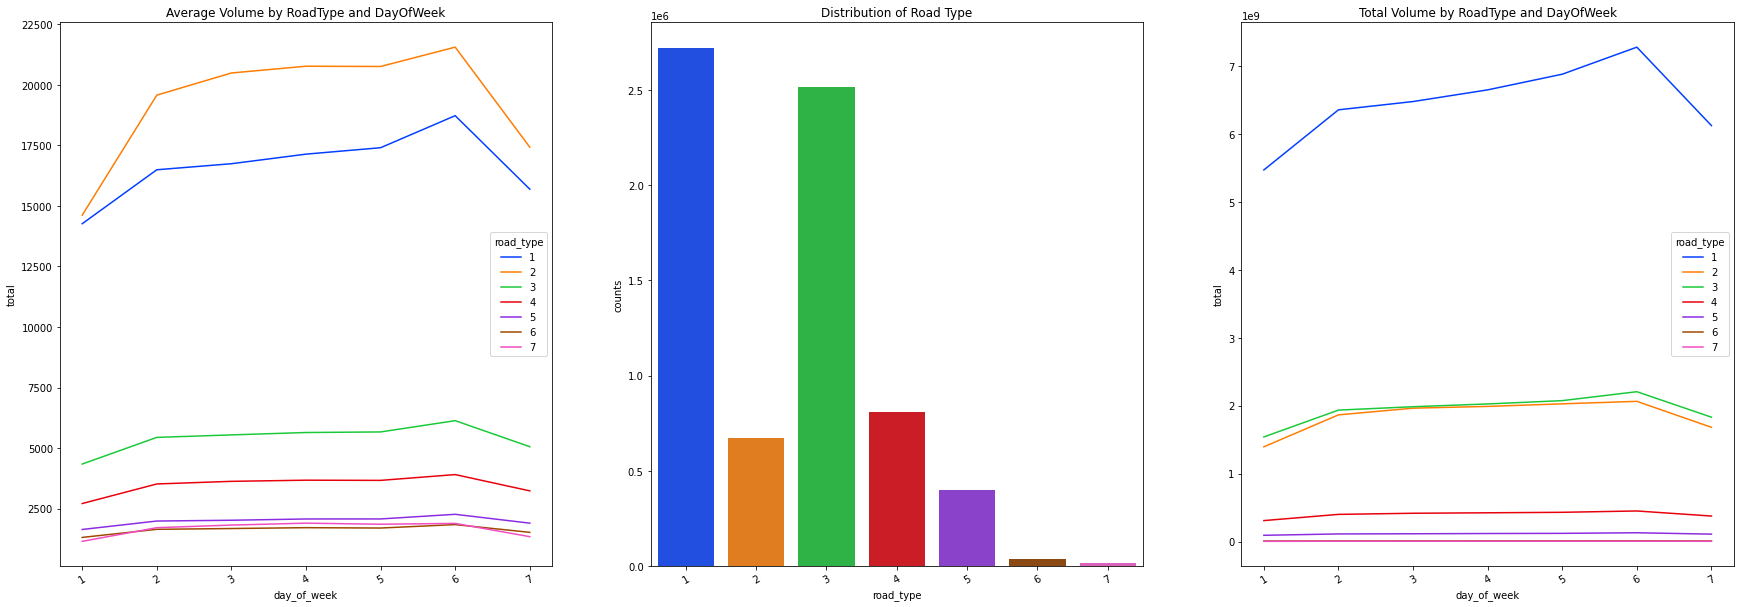

In [ ]:
fig, ax = plt.subplots(figsize=(30, 10), ncols=3)

ax[0].tick_params(axis='x', rotation=30)
ax[0].set_title('Average Volume by RoadType and DayOfWeek')
sns.lineplot(x='day_of_week', y='total', ci=None, hue='road_type', palette='bright', data=traffic_df.groupby(by=['day_of_week','road_type'], as_index=False)['total'].mean(), ax=ax[0])

ax[1].tick_params(axis='x', rotation=30)
ax[1].set_title('Distribution of Road Type')
sns.barplot(x='road_type', y='counts', ci=None, palette='bright', data=traffic_df['road_type'].value_counts().rename_axis('road_type').reset_index(name='counts'), ax=ax[1])

ax[2].tick_params(axis='x', rotation=30)
ax[2].set_title('Total Volume by RoadType and DayOfWeek')
sns.lineplot(x='day_of_week', y='total', ci=None, hue='road_type', palette='bright', data=traffic_df.groupby(by=['day_of_week','road_type'], as_index=False)['total'].sum(), ax=ax[2])

From the above chart, we observe:
* Road type 3 (Principal Arteries - Other) is the second most monitored road type, almost the same as Interstate (1). However, it has relatively low total volume and low average volume compared to interstate. Hence, **road type 3 may be under-utilized**.
* On the other hand, road type 2 (Principle arteries - Freeways & Expressways) has relative very few monitoring station compared to road type 1 & 3, but it has highest average volume (relatively much higher than the rest) and almost the same total volumes as road type 2. Hence, **road type 2 is likely to be over-utilized**.

### Clean up

In [ ]:
# Save df, in case it is needed later
with open('daily_df.pkl', 'wb') as pickle_out:
    pickle.dump(daily_df, pickle_out)

# Clean up df
del(daily_df)
gc.collect()

201

## Geographical Analysis

In this geographical analysis, we would like to find out the state and the county with the most traffic volumes.

In [ ]:
county_df = traffic_df.groupby(by=['fips_state_code', 'county_code'], as_index=False)['total'].sum()
county_df.dropna(inplace=True)

county_df['fips_state_code'] = county_df['fips_state_code'].astype('str')
county_df['county_code'] = county_df['county_code'].astype('str')

county_df.sort_values('total', ascending=False, inplace=True)

### By County

Text(0.5, 1.0, 'Road Type Distribution Overall')

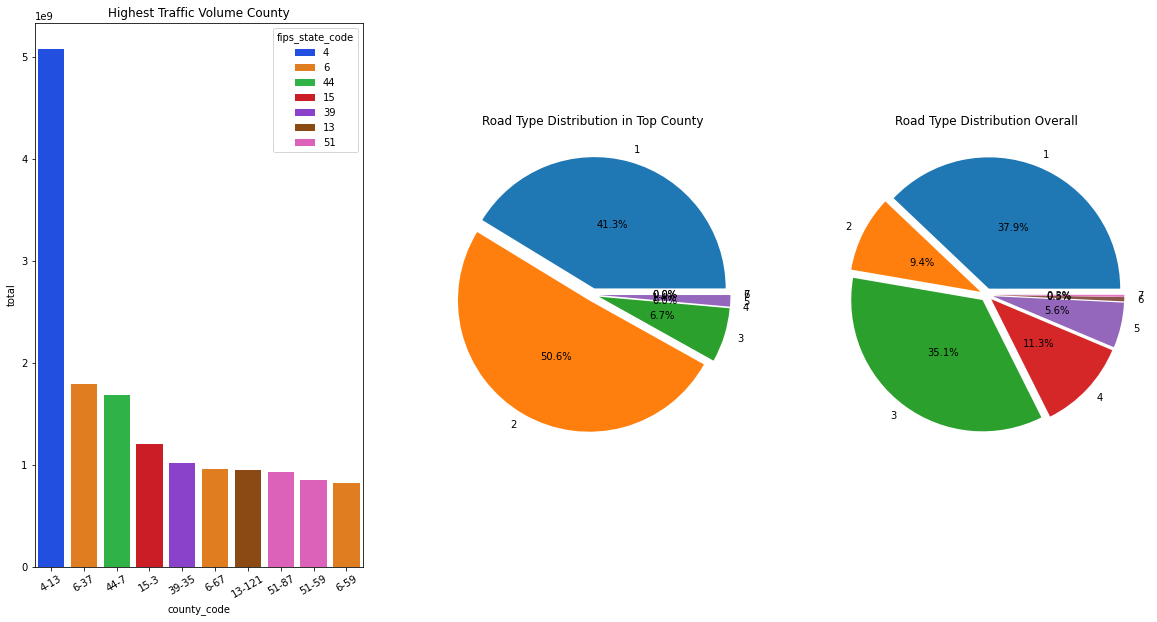

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=3)

ax[0].tick_params(axis='x', rotation=30)
ax[0].set_title('Highest Traffic Volume County')
sns.barplot(x='county_code', y='total', ci=None, hue='fips_state_code', palette='bright', dodge=False, data=county_df.head(10), ax=ax[0])


#############
max_county = county_df.loc[county_df['total'].idxmax()]
topcounty_df = traffic_df[(max_county['fips_state_code']==traffic_df['fips_state_code'].astype('str')) &
                          (max_county['county_code']==traffic_df['county_code'].astype('str'))]

#Using matplotlib
data = topcounty_df.groupby('road_type').size()
ax[1].pie(x=data, autopct="%.1f%%", explode=[0.05]*7, labels=data.keys(), pctdistance=0.5)
ax[1].set_title('Road Type Distribution in Top County')


##################
ax[2].pie(x=traffic_df.groupby('road_type').size(), autopct="%.1f%%", explode=[0.05]*7, labels=data.keys(), pctdistance=0.5)
ax[2].set_title('Road Type Distribution Overall')

From the above chart, Maricopa county (13) in Arizona (04) has the most traffic volume by far. The composition of road being monitored is more than 98% consists of Interstate (road type 1, 41.3%) and principal arteries (50.6% + 6.7%). The composition is much higher than overall average of ~82%.

### By State

In [ ]:
state_df = county_df.groupby(by='fips_state_code', as_index=False)['total'].sum()
state_df.sort_values('total', ascending=False, inplace=True)
state_df[:10]

,fips_state_code,total
43,51,9.188695e+09
48,6,6.711453e+09
31,4,5.600393e+09
3,12,4.813219e+09
30,39,4.074504e+09
4,13,3.440364e+09
39,48,2.791692e+09
44,53,2.705267e+09
35,44,2.442957e+09
17,26,2.309091e+09


Text(0.5, 1.0, 'Road Type Distribution Overall')

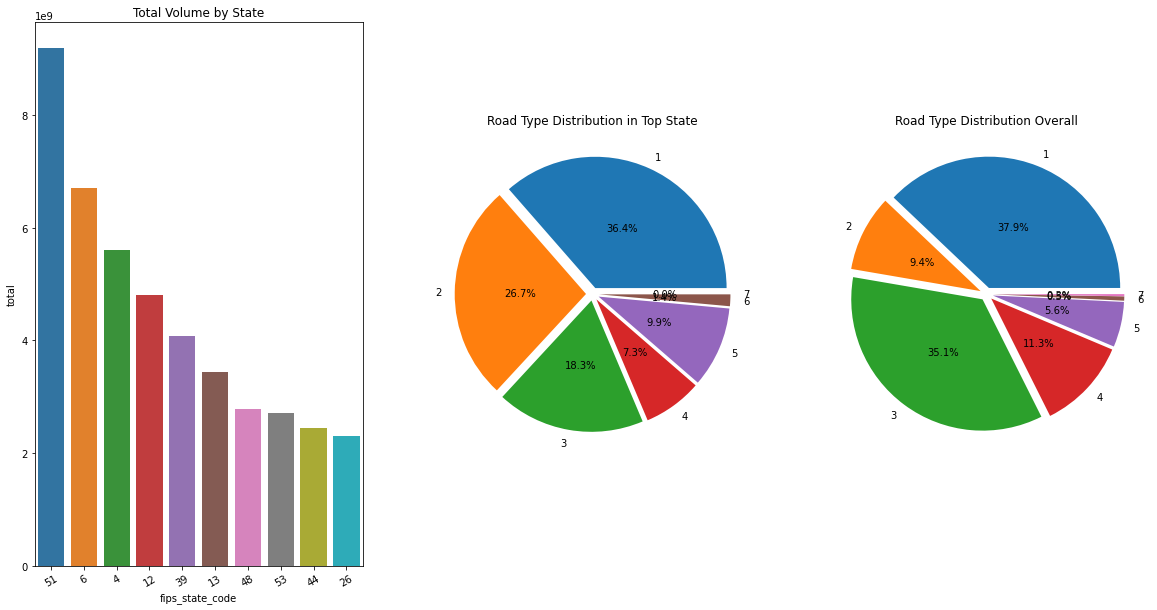

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10), ncols=3)

ax[0].tick_params(axis='x', rotation=30)
ax[0].set_title('Total Volume by State')
sns.barplot(x='fips_state_code', y='total', ci=None, data=state_df[:10], ax=ax[0])

#############
max_state = state_df.loc[state_df['total'].idxmax()]
state = max_county['fips_state_code']

topstate_df = traffic_df[(state==traffic_df['fips_state_code'].astype('str'))]
data = topstate_df.groupby('road_type').size()

#Using matplotlib
ax[1].pie(x=data, autopct="%.1f%%", explode=[0.05]*7, labels=data.keys(), pctdistance=0.5)
ax[1].set_title('Road Type Distribution in Top State')


##################
ax[2].pie(x=traffic_df.groupby('road_type').size(), autopct="%.1f%%", explode=[0.05]*7, labels=data.keys(), pctdistance=0.5)
ax[2].set_title('Road Type Distribution Overall')

The state with the most traffic volume monitored is Virginia (51) while its road types composition is about similar to overal, interstate 36.4% vs 37.9%  and  principal arteries (26.7% + 18.3%) vs (9.4% + 35.1%).
<br/>This finding is aligned with station distribution accross state, i.e. Virginia has most number of monitoring station.

### Clean up

In [ ]:
# Save df, in case it is needed later
with open('county_df.pkl', 'wb') as pickle_out:
    pickle.dump(county_df, pickle_out)

# Clean up df
del(county_df); del(topcounty_df); del(state_df); del(topstate_df);
gc.collect()

76

# Clusters Analysis

In Cluters Analysis, we want to find a hidden pattern in the data. We apply the clustering in two approaches:
* (Total) Volume: clustering analysis can be used as the starting point of road classification for policy making
* Hourly Distribution: in the above exploratory analysis, hourly distribution is clearly clustered around the location type (Rural & Urban). Here, we want to check/confirm the ealier observation.

<p>As the dataset is very large, we use sampling technique for the analysis to run properly in standard Google Colab environment.

In [ ]:
!pip install kmodes

import numpy as np
import pandas as pd
from kmodes.kprototypes import KPrototypes

In [ ]:
sample_pct  = 0.01
default_n_clusters = 3
max_n_clusters = 6
n_iteration = 5

## Volume Clustering

Volume clustering uses only Total Volumes (sum of hourly volumes) and category variables. 

In [ ]:
features_cols = category_cols + ['total']

dailycluster_df = traffic_df.sample(frac=sample_pct,random_state=1)[features_cols]
dailycluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71679 entries, 4019613 to 2250549
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   day_of_data                71679 non-null  category
 1   month_of_data              71679 non-null  category
 2   day_of_week                71679 non-null  category
 3   direction_of_travel        71679 non-null  category
 4   fips_state_code            71679 non-null  category
 5   functional_classification  71679 non-null  category
 6   lane_of_travel             71679 non-null  category
 7   road_type                  71679 non-null  category
 8   location_type              71679 non-null  category
 9   county_code                71679 non-null  category
 10  total                      71679 non-null  int32   
dtypes: category(10), int32(1)
memory usage: 1.7 MB


In [ ]:
categorical_features_idx = [dailycluster_df.columns.get_loc(x) for x in category_cols]
categorical_features_idx

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Analysing n_cluster =  0
Analysing n_cluster =  1
Analysing n_cluster =  2
Cost of n_clusters 2  is 5792804814036.457
Analysing n_cluster =  3
Cost of n_clusters 3  is 2973795522733.12
Analysing n_cluster =  4
Cost of n_clusters 4  is 1774309332980.4114
Analysing n_cluster =  5
Cost of n_clusters 5  is 1224688153722.5884
Analysing n_cluster =  6
Cost of n_clusters 6  is 934602063978.0286


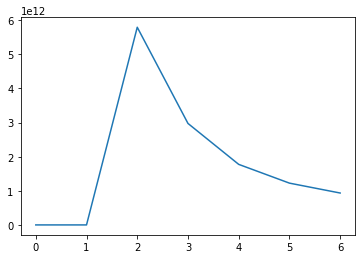

In [ ]:
# optimize number of cluster
cost = []
clusters = []
kprotos = []
for k in list(range(max_n_clusters+1)):
    print('Analysing n_cluster = ', k)
    if k < 2:
        kprotos.append([])
        clusters.append([])
        cost.append(0);
        continue
    kproto = KPrototypes(n_clusters=k, init='Cao', max_iter=n_iteration)
    cluster = kproto.fit_predict(dailycluster_df, categorical=categorical_features_idx)
    
    kprotos.append(kproto)
    clusters.append(cluster)
    cost.append(kproto.cost_)
    print('Cost of n_clusters',k,' is', kproto.cost_)
    
plt.plot(cost)

In [ ]:
#kproto = KPrototypes(n_clusters=default_n_clusters, verbose=2, max_iter=n_iteration)
#cluster = kproto.fit_predict(dailycluster_df.values, categorical=categorical_features_idx)

In [ ]:
kprotos[5].cluster_centroids_

array([['22408.247172005496', '13', '5', '6', '5', '51', '1U', '0', '1',
        'U', '44-7'],
       ['104984.9093922652', '20', '3', '6', '1', '4', '1U', '0', '1',
        'U', '4-13'],
       ['57150.04029990628', '20', '10', '3', '1', '51', '1U', '0', '1',
        'U', '4-13'],
       ['10417.460111582663', '16', '5', '3', '1', '12', '1U', '1', '1',
        'U', '39-35'],
       ['2814.252028264852', '25', '1', '1', '5', '12', '3R', '1', '3',
        'R', '16-1']], dtype='<U32')

The center of clusters are clearly influenced by sum of traffic volume during the day: ~2814, ~10417, ~22408, ~57150, ~104984.

In [ ]:
clusters_dict=[]
for c in clusters[5]:
    clusters_dict.append(c)

#clusters_dict

In [ ]:
dailycluster_df['clusters_id'] = clusters[5]
dailycluster_df['clusters_id'].value_counts()

4    38555
3    20873
0     9264
2     2105
1      882
Name: clusters_id, dtype: int64

In [ ]:
for i in range(5):
    print(dailycluster_df[i == dailycluster_df['clusters_id']].head())

        day_of_data month_of_data day_of_week  ... county_code  total clusters_id
4643411          25             3           4  ...      51-155  19926           0
4098819          24             3           3  ...       51-59  39677           0
3598633          18            12           6  ...      51-540  23509           0
5768756          12             3           5  ...       12-86  22632           0
3305664          21             6           1  ...        8-31  28662           0

[5 rows x 12 columns]
        day_of_data month_of_data day_of_week  ... county_code   total clusters_id
645654           19             5           3  ...        4-13   85022           1
4730606          30             8           1  ...       24-31  103481           1
6229238          30            11           2  ...        4-13  116899           1
5728945           8            10           5  ...       25-17   96319           1
4852929          25             8           3  ...       45-63   93295

In [ ]:
# Clean up df
del(dailycluster_df); del(traffic_df)
gc.collect()

108

## Hourly Distribution Clustering

In [ ]:
# Load df
with open('hourly_df.pkl', 'rb') as pickle_in:
    hourly_df = pickle.load(pickle_in)

hourly_df.dropna(inplace=True)
hourly_df.head()

,day_of_data,month_of_data,day_of_week,direction_of_travel,fips_state_code,functional_classification,lane_of_travel,road_type,location_type,county_code,0000_to_0100,0100_to_0200,0200_to_0300,0300_to_0400,0400_to_0500,0500_to_0600,0600_to_0700,0700_to_0800,0800_to_0900,0900_to_1000,1000_to_1100,1100_to_1200,1200_to_1300,1300_to_1400,1400_to_1500,1500_to_1600,1600_to_1700,1700_to_1800,1800_to_1900,1900_to_2000,2000_to_2100,2100_to_2200,2200_to_2300,2300_to_2400
0,7,4,3,1,56,3R,1,3,R,56-39,0.001959,0.001470,0.000979,0.001959,0.021057,0.038208,0.056793,0.070496,0.064636,0.056305,0.073486,0.090088,0.082764,0.066589,0.063171,0.043579,0.059753,0.060730,0.053864,0.033783,0.035736,0.013710,0.005878,0.002939
1,26,12,7,5,56,3R,1,3,R,56-39,0.003214,0.000000,0.000292,0.000292,0.001461,0.011978,0.015488,0.012856,0.028641,0.041779,0.068115,0.097290,0.113647,0.104614,0.097900,0.106079,0.085632,0.070740,0.037689,0.029221,0.013443,0.030685,0.023087,0.005844
2,23,9,4,1,56,3R,1,3,R,56-39,0.001669,0.000668,0.000668,0.001836,0.010185,0.037231,0.048248,0.052582,0.077942,0.086487,0.083984,0.078125,0.073792,0.072632,0.061768,0.055908,0.059753,0.060760,0.044403,0.030380,0.027878,0.021530,0.008850,0.002838
3,13,4,2,1,56,3R,1,3,R,56-39,0.001706,0.000427,0.000427,0.000853,0.015778,0.030701,0.051178,0.068237,0.063965,0.049896,0.062683,0.080200,0.088684,0.075073,0.076782,0.062683,0.060974,0.060974,0.047333,0.034973,0.034546,0.021317,0.008530,0.002132
4,22,11,1,1,56,3R,1,3,R,56-39,0.005775,0.001733,0.001156,0.001156,0.022537,0.038116,0.062378,0.036407,0.029465,0.030624,0.087830,0.105713,0.095886,0.094177,0.091858,0.067017,0.061829,0.034668,0.027145,0.028305,0.040436,0.020218,0.008667,0.006931


In [ ]:
features_cols = category_cols + hour_cols

hourlycluster_df = hourly_df.sample(frac=sample_pct,random_state=1)[features_cols]
hourlycluster_df.info()

categorical_features_idx = [hourlycluster_df.columns.get_loc(x) for x in category_cols]
#categorical_features_idx

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71435 entries, 327862 to 1248797
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   day_of_data                71435 non-null  category
 1   month_of_data              71435 non-null  category
 2   day_of_week                71435 non-null  category
 3   direction_of_travel        71435 non-null  category
 4   fips_state_code            71435 non-null  category
 5   functional_classification  71435 non-null  category
 6   lane_of_travel             71435 non-null  category
 7   road_type                  71435 non-null  category
 8   location_type              71435 non-null  category
 9   county_code                71435 non-null  category
 10  0000_to_0100               71435 non-null  float16 
 11  0100_to_0200               71435 non-null  float16 
 12  0200_to_0300               71435 non-null  float16 
 13  0300_to_0400            

Analysing n_cluster =  0
Analysing n_cluster =  1
Analysing n_cluster =  2
Cost of n_clusters 2  is 7840.259552170109
Analysing n_cluster =  3
Cost of n_clusters 3  is 7505.64685976461
Analysing n_cluster =  4
Cost of n_clusters 4  is 7237.6370706482985
Analysing n_cluster =  5
Cost of n_clusters 5  is 7063.623292965441
Analysing n_cluster =  6
Cost of n_clusters 6  is 6920.49924632588


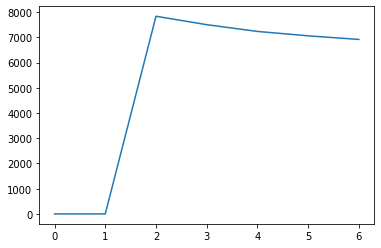

In [ ]:
# optimize number of cluster
cost = []
clusters = []
kprotos = []
for k in list(range(max_n_clusters+1)):
    print('Analysing n_cluster = ', k)
    if k < 2:
        kprotos.append([])
        clusters.append([])
        cost.append(0);
        continue
    kproto = KPrototypes(n_clusters=k, init='Cao', max_iter=n_iteration)
    cluster = kproto.fit_predict(hourlycluster_df, categorical=categorical_features_idx)
    
    kprotos.append(kproto)
    clusters.append(cluster)
    cost.append(kproto.cost_)
    print('Cost of n_clusters',k,' is', kproto.cost_)
    
plt.plot(cost)

As expected, there are 2 clusters observed based on hourly data.

In [ ]:
kprotos[2].cluster_centroids_

array([['0.010505809711708483', '0.00712600803294642',
        '0.005838034507948839', '0.006006160678667561',
        '0.009706393998043641', '0.021008800872437304',
        '0.03972417192989065', '0.05629002331024959',
        '0.05437394455063457', '0.05245738891922762',
        '0.05517470280295802', '0.05899890140978069',
        '0.06254065111393621', '0.06357454974799569',
        '0.06715705201614615', '0.07279276210578772',
        '0.07621197417983729', '0.0741477831690444',
        '0.05851924345570266', '0.0446561310019384',
        '0.0360149842082878', '0.029396321322849805',
        '0.022215439916116728', '0.015561648728975837', '7', '5', '5',
        '1', '12', '1U', '1', '1', 'U', '15-3'],
       ['0.008242997303159017', '0.0057202069638572425',
        '0.004723806625588118', '0.005055304668730344',
        '0.008315548377528046', '0.017517975201659444',
        '0.03239314791110382', '0.04800726789126173',
        '0.050454878520877516', '0.05515179263964183',
     

The center of clusters are clearly based on location type: Rural and Urban.

In [ ]:
clusters_dict=[]
for c in clusters[2]:
    clusters_dict.append(c)

#clusters_dict

In [ ]:
hourlycluster_df['clusters_id'] = clusters[2]
hourlycluster_df['clusters_id'].value_counts()

0    37864
1    33571
Name: clusters_id, dtype: int64

In [ ]:
for i in range(2):
    print(hourlycluster_df[i == hourlycluster_df['clusters_id']].head())

        day_of_data month_of_data  ... 2300_to_2400 clusters_id
327862           26             4  ...     0.018753           0
4231443          17             4  ...     0.016708           0
30299             3             2  ...     0.012909           0
4528386          13             8  ...     0.025528           0
4807731          16             3  ...     0.013130           0

[5 rows x 35 columns]
        day_of_data month_of_data  ... 2300_to_2400 clusters_id
2125558          15            10  ...     0.010834           1
2235666          14             4  ...     0.004284           1
46450            12             9  ...     0.020599           1
4129643          13            12  ...     0.015221           1
3682830          18            10  ...     0.009636           1

[5 rows x 35 columns]


# Summary

1. The traffic volume data corresponds to the number of monitoring stations involved. At least 6 common states of 10 highest traffic volumes are also in the 10 highest number of monitoring stations.
2. The monitoring stations are mostly Interstate and Principal Arteries (road types: 1, 2, 3). Hence, most traffic recorded are also in these road types.
3. Based on location types, Urban traffic has a clearer morning peak compared to Rural. While based on road types, there is no significant pattern differences observed.
4. Based on day of the week, Weekdays traffic has morning & evening peaks while Weekend traffic slowly rises relatively flat peak in the afternoon.
5. North/South directions have the most share of traffic volumes, significantly higher than East/West.
6. During the year, the traffic volumes peak around summer-break months, i.e. May to August.
7. The data suggests that Principle Arteries (Freeways/Highways) are over-utilized compared to Interstate and Principle Arteries (Other).

#Recommendation

1. As Kaggle dataset only contains Station and Traffic Volume data, using the original FHWA dataset (which also contains Speed, Weight, and Vehicle classification) may yield mroe meaningful observations.
2. Further analysis based on Volume clustering should be done to better characterise/classify roads to inform policy making.
3. Better analysis by employing other sampling and/or data chunking techniques.

# WORK

In [ ]:
major_holidays = ['1/1', #New Year's Day, Thu, 1 Jan 2015
                  '1/17', '1/18', '1/19', #Martin Luther King Jr. Day, Mon, 19 Jan 2015
                  '5/23', '5/24', '5/25', #Memorial Day, Mon, 25 May 2015
                  '7/3', '7/4', '7/5', #Independence Day, Fri, 3 Jul 2015
                  '9/5', '9/6', '9/7', #Labor Day, Mon, 7 Sep 2015
                  '11/26', #Thanksgiving, Thu, 26 Nov 2015
                  '12/24', '12/25', '12/26', '12/27'] #Christmas Day, Fri, 25 Dec 2015

daily_df['holiday'] = daily_df['date'].isin(major_holidays)
daily_df


NameError: ignored

In [ ]:
daycategory_df = pd.DataFrame(
    data = [daily_df[daily_df['day_of_week'].isin(weekend)]['total'].mean(),
            daily_df[daily_df['date'].isin(major_holidays)]['total'].mean(), 
            daily_df[~daily_df['day_of_week'].isin(weekend) & ~daily_df['date'].isin(major_holidays)]['total'].mean()],
    index = [['weekend', 'holiday', 'weekday']],
    columns = ['mean'])

daycategory_df

#sns.boxplot(x='day_of_week', y='Relative_Traffic_Volume', data=rt_day_location_urban_df1)